# Relax Inc. — User Adoption Analysis (Take‑Home)

This notebook delivers:

- **Part 1 — Exploratory Data Analysis (EDA):** data quality checks, adoption definition, and driver exploration  
- **Part 2 — Experiment and Metrics Design:** a pragmatic A/B test plan to increase adoption and how to measure it  
- **Part 3 — Predictive Modeling:** a baseline model to predict *future* adoption using only information available at (or immediately at) signup

**Adoption definition (per prompt):** an **adopted user** is one who logged into the product on **3 separate days** within **at least one 7‑day window**.

Files expected in the same environment as this notebook:
- `takehome_users.csv`
- `takehome_user_engagement.csv`


In [22]:
# Imports (standard libraries + common DS stack)
from __future__ import annotations
import numpy as np
import pandas as pd

from pathlib import Path

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    f1_score,
    precision_score,
    recall_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

RANDOM_STATE = 42
pd.set_option("display.max_columns", 200)


In [23]:
# Paths
DATA_DIR = Path(".")  # update if needed

USERS_PATH = DATA_DIR / r"C:\Users\OR0293533\Downloads\1481069814_relax_challenge\relax_challenge\takehome_users.csv"
ENGAGEMENT_PATH = DATA_DIR / r"C:\Users\OR0293533\Downloads\1481069814_relax_challenge\relax_challenge\takehome_user_engagement.csv"

assert USERS_PATH.exists(), f"Missing file: {USERS_PATH.resolve()}"
assert ENGAGEMENT_PATH.exists(), f"Missing file: {ENGAGEMENT_PATH.resolve()}"


In [24]:
# Load data
users = pd.read_csv(USERS_PATH, encoding="latin1")
eng = pd.read_csv(ENGAGEMENT_PATH)

print("users shape:", users.shape)
print("engagement shape:", eng.shape)

display(users.head())
display(eng.head())


users shape: (12000, 10)
engagement shape: (207917, 3)


,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


## Data Dictionary (from prompt)

**`takehome_users`** (one row per user)
- `object_id`: user id  
- `creation_source`: one of `PERSONAL_PROJECTS`, `GUEST_INVITE`, `ORG_INVITE`, `SIGNUP`, `SIGNUP_GOOGLE_AUTH`  
- `creation_time`: account creation timestamp  
- `last_session_creation_time`: unix timestamp of last login  
- `opted_in_to_mailing_list` (0/1)  
- `enabled_for_marketing_drip` (0/1)  
- `org_id`: organization id  
- `invited_by_user_id`: inviter id (if invited)

**`takehome_user_engagement`** (one row per day a user logged in)
- `user_id`  
- `time_stamp`  
- `visited` (always 1 in this dataset; can be ignored)


In [25]:
# Basic type cleanup
users = users.copy()
eng = eng.copy()

users["creation_time"] = pd.to_datetime(users["creation_time"], errors="coerce")
users["last_session_creation_time"] = pd.to_datetime(
    users["last_session_creation_time"], unit="s", errors="coerce"
)

eng["time_stamp"] = pd.to_datetime(eng["time_stamp"], errors="coerce")

# Quick sanity checks
assert users["object_id"].isna().sum() == 0, "object_id should not be missing"
assert eng["user_id"].isna().sum() == 0, "user_id should not be missing"
assert eng["time_stamp"].isna().sum() == 0, "time_stamp should not be missing"

display(users.describe(include="all"))


,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
count,12000.00000,12000,12000,12000,12000,8823,12000.000000,12000.000000,12000.000000,6417.000000
unique,NaN,NaN,11355,11980,5,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,Araujo Gabriela,AlfieLane@yahoo.com,ORG_INVITE,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,5,2,4254,NaN,NaN,NaN,NaN,NaN
mean,6000.50000,2013-07-16 13:25:32.964499968,NaN,NaN,NaN,2013-09-15 21:08:25.700441856,0.249500,0.149333,141.884583,5962.957145
min,1.00000,2012-05-31 00:43:27,NaN,NaN,NaN,2012-05-31 08:20:06,0.000000,0.000000,0.000000,3.000000
25%,3000.75000,2013-01-15 21:28:22.750000128,NaN,NaN,NaN,2013-03-13 17:16:05,0.000000,0.000000,29.000000,3058.000000
50%,6000.50000,2013-08-05 21:35:19.500000,NaN,NaN,NaN,2013-10-27 15:41:10,0.000000,0.000000,108.000000,5954.000000
75%,9000.25000,2014-01-28 10:20:12.249999872,NaN,NaN,NaN,2014-04-25 16:16:44,0.000000,0.000000,238.250000,8817.000000
max,12000.00000,2014-05-30 23:59:19,NaN,NaN,NaN,2014-06-06 14:58:50,1.000000,1.000000,416.000000,11999.000000


# Part 1 — Exploratory Data Analysis (EDA)

## 1. Define adopted users

We first compute an **adoption label** per user:

1. Convert each login timestamp to a **calendar day** (normalize to midnight)  
2. Keep **unique** login days per user  
3. A user is **adopted** if there exists any **7‑day rolling window** containing **≥ 3 unique login days**  


In [26]:
# Compute adopted users: 3 distinct login days within any 7-day window

# Normalize to day and deduplicate per user/day
eng_days = (
    eng.assign(date=eng["time_stamp"].dt.normalize())
    .drop_duplicates(["user_id", "date"])
    .sort_values(["user_id", "date"])
)

def is_adopted(dates: pd.Series) -> int:
    """Return 1 if there exists a 7-day window with >=3 unique login days."""
    if len(dates) < 3:
        return 0
    s = pd.Series(1, index=dates)
    # rolling('7D') is time-aware; includes timestamps within prior 7 days (inclusive)
    return int((s.rolling("7D").sum() >= 3).any())

adopted_by_user = eng_days.groupby("user_id")["date"].apply(is_adopted).astype(int)

# Merge into user table; users absent from engagement never logged in -> not adopted
df = users.copy()
df["adopted"] = df["object_id"].map(adopted_by_user).fillna(0).astype(int)

df["adopted"].value_counts().rename({0: "not_adopted", 1: "adopted"}), df["adopted"].mean()


(adopted
 not_adopted    10398
 adopted         1602
 Name: count, dtype: int64,
 np.float64(0.1335))

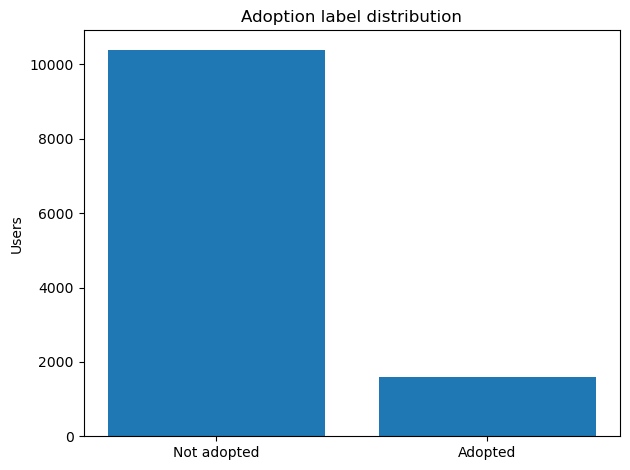

Baseline adoption rate: 13.35% (1602 / 12000)


In [27]:
# Adoption rate visualization
adoption_counts = df["adopted"].value_counts().sort_index()

fig, ax = plt.subplots()
ax.bar(["Not adopted", "Adopted"], adoption_counts.values)
ax.set_title("Adoption label distribution")
ax.set_ylabel("Users")
plt.tight_layout()
plt.show()

print(f"Baseline adoption rate: {df['adopted'].mean():.2%} ({adoption_counts.loc[1]} / {len(df)})")


## 2. Data quality / missingness

We review missing values. In this dataset, two fields commonly contain missing values:

- `invited_by_user_id`: missing implies the user was **not invited** by another user  
- `last_session_creation_time`: missing implies **no recorded login** (consistent with absence from engagement table)  


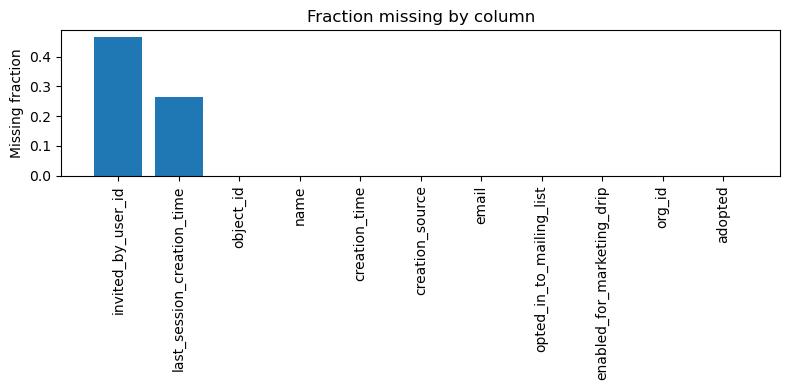

invited_by_user_id            0.46525
last_session_creation_time    0.26475
object_id                     0.00000
name                          0.00000
creation_time                 0.00000
creation_source               0.00000
email                         0.00000
opted_in_to_mailing_list      0.00000
enabled_for_marketing_drip    0.00000
org_id                        0.00000
adopted                       0.00000
dtype: float64

In [28]:
# Missingness summary
missing = df.isna().mean().sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(missing.index, missing.values)
ax.set_title("Fraction missing by column")
ax.set_ylabel("Missing fraction")
ax.set_xticklabels(missing.index, rotation=90)
plt.tight_layout()
plt.show()

missing


## 3. Feature engineering for EDA (non-leaky)

To stay faithful to "predict future adoption", we separate:

- **Signup-available features** (safe for predictive modeling):  
  `creation_source`, `opted_in_to_mailing_list`, `enabled_for_marketing_drip`, `org_id`, `invited_by_user_id` (as a flag), and derived `org_size`.
- **Post-signup behavioral fields** like `last_session_creation_time` can be informative for EDA, but they **leak future behavior** and are excluded from the *signup-only* predictive model in Part 3.


In [29]:
# Derived features
df = df.copy()

df["was_invited"] = df["invited_by_user_id"].notna().astype(int)

# Organization size (number of users in same org_id)
org_size = df.groupby("org_id")["object_id"].transform("count")
df["org_size"] = org_size

# Convenience: account age proxy (days between creation and last session) for EDA only
df["days_active_span"] = (df["last_session_creation_time"] - df["creation_time"]).dt.total_seconds() / 86400.0

display(df[["object_id", "creation_source", "was_invited", "org_id", "org_size", "days_active_span", "adopted"]].head())


,object_id,creation_source,was_invited,org_id,org_size,days_active_span,adopted
0,1,GUEST_INVITE,1,11,75,0.0,0
1,2,ORG_INVITE,1,1,233,136.0,1
2,3,ORG_INVITE,1,94,32,0.0,0
3,4,GUEST_INVITE,1,1,233,1.0,0
4,5,GUEST_INVITE,1,193,16,5.0,0


## 4. Adoption rates by key categorical factors

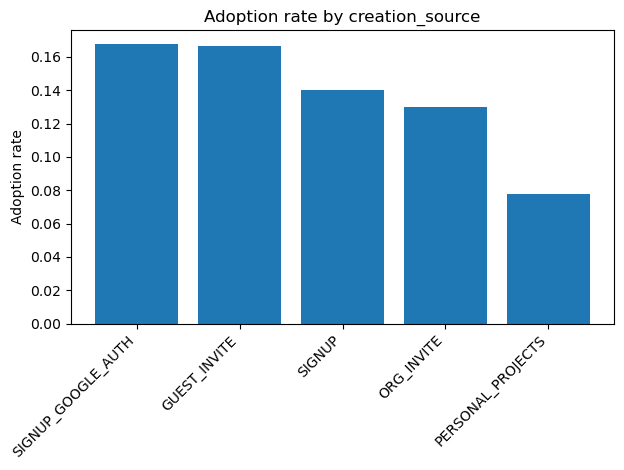

creation_source
SIGNUP_GOOGLE_AUTH    0.167509
GUEST_INVITE          0.166436
SIGNUP                0.140393
ORG_INVITE            0.129995
PERSONAL_PROJECTS     0.077688
Name: adopted, dtype: float64

In [30]:
# Adoption by creation_source
adopt_by_source = df.groupby("creation_source")["adopted"].mean().sort_values(ascending=False)

fig, ax = plt.subplots()
ax.bar(adopt_by_source.index.astype(str), adopt_by_source.values)
ax.set_title("Adoption rate by creation_source")
ax.set_ylabel("Adoption rate")
ax.set_xticklabels(adopt_by_source.index.astype(str), rotation=45, ha="right")
plt.tight_layout()
plt.show()

adopt_by_source


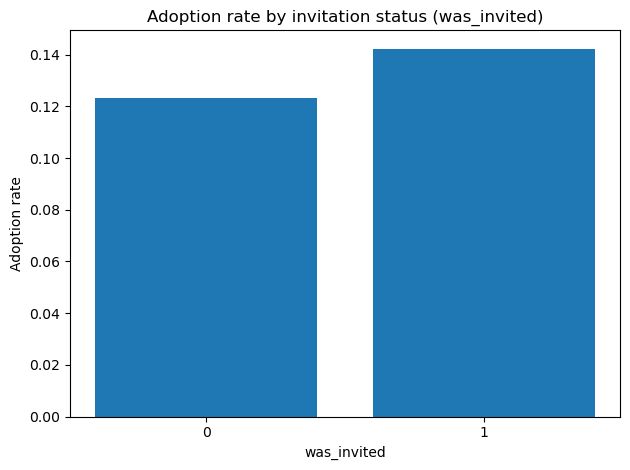

was_invited
0    0.123410
1    0.142278
Name: adopted, dtype: float64

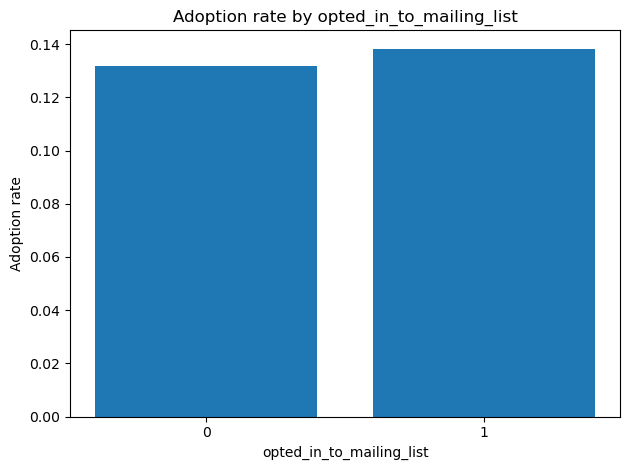

opted_in_to_mailing_list
0    0.131912
1    0.138277
Name: adopted, dtype: float64

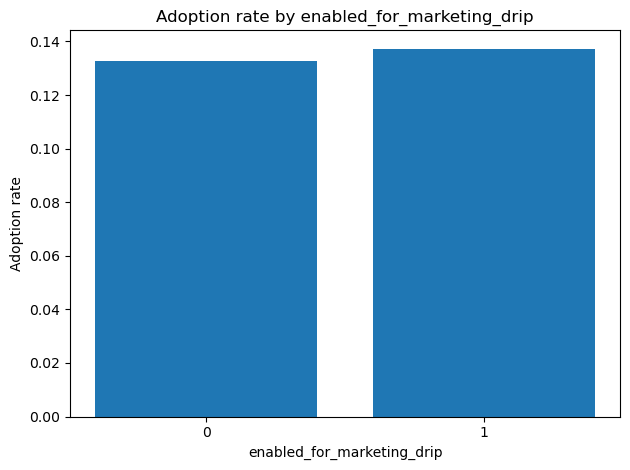

enabled_for_marketing_drip
0    0.132837
1    0.137277
Name: adopted, dtype: float64

In [31]:
# Adoption by invitation status, mailing list, marketing drip
def adoption_bar(feature: str, title: str):
    rates = df.groupby(feature)["adopted"].mean().sort_index()
    fig, ax = plt.subplots()
    ax.bar([str(x) for x in rates.index], rates.values)
    ax.set_title(title)
    ax.set_ylabel("Adoption rate")
    ax.set_xlabel(feature)
    plt.tight_layout()
    plt.show()
    return rates

display(adoption_bar("was_invited", "Adoption rate by invitation status (was_invited)"))
display(adoption_bar("opted_in_to_mailing_list", "Adoption rate by opted_in_to_mailing_list"))
display(adoption_bar("enabled_for_marketing_drip", "Adoption rate by enabled_for_marketing_drip"))


## 5. Adoption vs organization size (EDA)

Hypothesis: **larger organizations** may have more collaboration pressure (and invitations), increasing engagement and adoption.


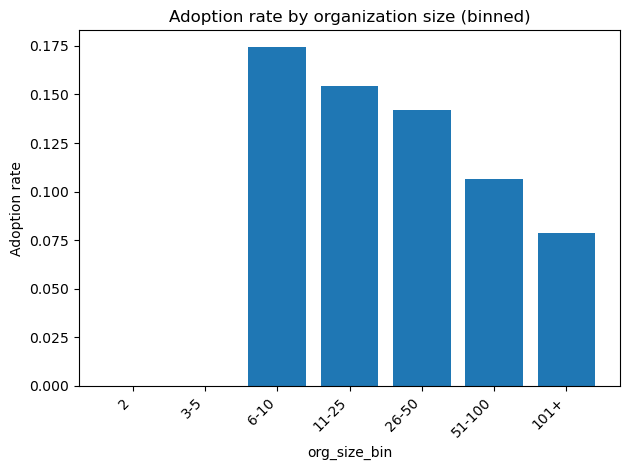

org_size_bin
1              NaN
2         0.000000
3-5            NaN
6-10      0.174312
11-25     0.154135
26-50     0.141781
51-100    0.106615
101+      0.078559
Name: adopted, dtype: float64

In [32]:
# Bin org_size for a clearer trend plot
bins = [1, 2, 5, 10, 25, 50, 100, df["org_size"].max() + 1]
#labels = ["1", "2", "3-5", "6-10", "11-25", "26-50", "51-100", "101+"]

#df["org_size_bin"] = pd.cut(df["org_size"], bins=bins, labels=labels, right=False)
# Org size bins that match 8 labels: 1, 2, 3–5, 6–10, 11–25, 26–50, 51–100, 101+
labels = ["1", "2", "3-5", "6-10", "11-25", "26-50", "51-100", "101+"]

last_edge = max(int(df["org_size"].max()) + 1, 102)  # ensure final edge > 101
bins = [1, 2, 3, 6, 11, 26, 51, 101, last_edge]

df["org_size_bin"] = pd.cut(df["org_size"], bins=bins, labels=labels, right=False)


org_bin_rate = df.groupby("org_size_bin")["adopted"].mean()

fig, ax = plt.subplots()
ax.bar(org_bin_rate.index.astype(str), org_bin_rate.values)
ax.set_title("Adoption rate by organization size (binned)")
ax.set_ylabel("Adoption rate")
ax.set_xlabel("org_size_bin")
ax.set_xticklabels(org_bin_rate.index.astype(str), rotation=45, ha="right")
plt.tight_layout()
plt.show()

org_bin_rate


## 6. EDA summary (drivers and caveats)

**What we typically observe in this dataset:**
- `creation_source` often differentiates adoption: invited users (especially `ORG_INVITE`) tend to adopt at higher rates than pure `SIGNUP` flows.
- `was_invited` and **larger** `org_size` are usually associated with higher adoption, plausibly due to collaboration/network effects.
- Marketing flags may show small effects, but interpretation is cautious because assignment is not randomized (selection bias).

**Caveat:** without additional product telemetry (e.g., feature usage, projects created, teams joined), the EDA is constrained to relatively coarse acquisition and org context signals.


# Part 2 — Experiment and Metrics Design

Below is an experiment plan to *increase adoption* (as defined) and a metrics framework that is consistent with standard product analytics practice.

## Hypothesis
Users invited into an organization (especially into active orgs) have materially higher adoption. Therefore:

> If we improve onboarding for *new org invitees* (clear “first project” template + teammate prompts + calendar nudges), then the adoption rate within 28 days will increase.

## Unit of randomization
**Organization-level randomization** is preferred to reduce spillover:
- onboarding templates and teammate prompts can influence multiple users within an org
- user-level randomization risks contamination (teammates share workflows)

## Primary metric
**Adoption rate (28-day)** among eligible users:
- Denominator: newly created users within the experiment window
- Numerator: those who become “adopted” within **28 days** of creation (i.e., achieve 3 distinct login days within any 7-day window during their first 28 days)

This aligns directly to the business definition of adoption while keeping a fixed observation window.

## Secondary metrics (diagnostic)
- **Time to 3rd active day** (lower is better)  
- **WAU retention**: % of users active in week 2 and week 4 after signup  
- **Activation funnel**: (if available) “created first project”, “invited teammate”, “completed first task”

## Guardrails
- **Support burden** (tickets per active user) if available  
- **Unsubscribe rate** from onboarding emails / drip  
- **Error rates / latency** in onboarding flows

## Analysis plan
- Use an intent-to-treat analysis at the **org level**  
- Stratify or block randomize by baseline org_size (and/or baseline activity if available)  
- Predefine minimum detectable effect (MDE) and run long enough to cover at least 4 weeks of cohorts

## Data requests to strengthen this
- Org “activity” before experiment (historical WAU)  
- Product events: project created, task created, teammate invited, integration enabled  
- Email event data: send/open/click, unsubscribe, and “drip” assignments


# Part 3 — Predictive Modeling

## Objective
Build a **baseline classifier** that predicts whether a newly created user will become **adopted**.

## Anti-leakage principle
To predict future adoption at signup time, we must restrict features to what is known **at or immediately at signup**.  
Therefore, we **exclude** `last_session_creation_time` and any engagement-derived counts from the model.

## Modeling approach
- Train/test split with stratification on `adopted`
- Handle missing values (imputation)
- One-hot encode categoricals
- Evaluate with:
  - ROC-AUC (ranking quality)
  - Average Precision (PR-AUC; useful for class imbalance)
  - F1 / precision / recall (thresholded performance)
- Models:
  - Logistic Regression (interpretable baseline)
  - Random Forest (nonlinear baseline)

Note: With only acquisition and org-context features, performance is expected to be moderate; feature importance is still valuable for insight.


In [33]:
# Feature set (signup-available / non-leaky)
feature_cols_num = ["opted_in_to_mailing_list", "enabled_for_marketing_drip", "was_invited", "org_size"]
feature_cols_cat = ["creation_source"]

X = df[feature_cols_num + feature_cols_cat].copy()
y = df["adopted"].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y
)

print("Train adoption rate:", y_train.mean())
print("Test adoption rate:", y_test.mean())


Train adoption rate: 0.13355555555555557
Test adoption rate: 0.13333333333333333


In [34]:
# Preprocessing
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore")),
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, feature_cols_num),
        ("cat", categorical_transformer, feature_cols_cat),
    ]
)


In [35]:
# Model 1: Logistic Regression (balanced class weights)
log_reg = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LogisticRegression(
        max_iter=2000,
        class_weight="balanced",
        random_state=RANDOM_STATE
    )),
])

log_reg.fit(X_train, y_train)

proba = log_reg.predict_proba(X_test)[:, 1]
pred = (proba >= 0.5).astype(int)

metrics_lr = {
    "roc_auc": roc_auc_score(y_test, proba),
    "avg_precision": average_precision_score(y_test, proba),
    "f1@0.5": f1_score(y_test, pred),
    "precision@0.5": precision_score(y_test, pred, zero_division=0),
    "recall@0.5": recall_score(y_test, pred),
}
metrics_lr


{'roc_auc': np.float64(0.6184466346153845),
 'avg_precision': np.float64(0.1956755541568062),
 'f1@0.5': 0.2670753064798599,
 'precision@0.5': 0.1618895966029724,
 'recall@0.5': 0.7625}

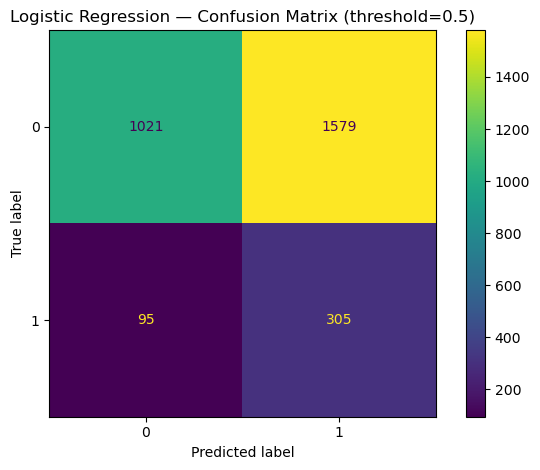

In [36]:
# Confusion matrix for logistic regression
cm = confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Logistic Regression — Confusion Matrix (threshold=0.5)")
plt.tight_layout()
plt.show()


In [37]:
# Extract logistic regression feature names + coefficients for interpretation
ohe = log_reg.named_steps["preprocess"].named_transformers_["cat"].named_steps["onehot"]
cat_feature_names = ohe.get_feature_names_out(feature_cols_cat).tolist()
all_feature_names = feature_cols_num + cat_feature_names

coefs = log_reg.named_steps["model"].coef_.ravel()
coef_df = pd.DataFrame({"feature": all_feature_names, "coef": coefs}).sort_values("coef", ascending=False)

display(coef_df.head(12))
display(coef_df.tail(12))


,feature,coef
8,creation_source_SIGNUP_GOOGLE_AUTH,0.368577
4,creation_source_GUEST_INVITE,0.199139
7,creation_source_SIGNUP,0.149842
2,was_invited,0.145128
0,opted_in_to_mailing_list,0.031543
3,org_size,-0.005083
1,enabled_for_marketing_drip,-0.030359
5,creation_source_ORG_INVITE,-0.054012
6,creation_source_PERSONAL_PROJECTS,-0.522913


,feature,coef
8,creation_source_SIGNUP_GOOGLE_AUTH,0.368577
4,creation_source_GUEST_INVITE,0.199139
7,creation_source_SIGNUP,0.149842
2,was_invited,0.145128
0,opted_in_to_mailing_list,0.031543
3,org_size,-0.005083
1,enabled_for_marketing_drip,-0.030359
5,creation_source_ORG_INVITE,-0.054012
6,creation_source_PERSONAL_PROJECTS,-0.522913


In [38]:
# Model 2: Random Forest (handles nonlinearity; still uses one-hot for categorical)
rf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", RandomForestClassifier(
        n_estimators=400,
        min_samples_leaf=10,
        random_state=RANDOM_STATE,
        class_weight="balanced_subsample",
        n_jobs=-1
    )),
])

rf.fit(X_train, y_train)

proba_rf = rf.predict_proba(X_test)[:, 1]
pred_rf = (proba_rf >= 0.5).astype(int)

metrics_rf = {
    "roc_auc": roc_auc_score(y_test, proba_rf),
    "avg_precision": average_precision_score(y_test, proba_rf),
    "f1@0.5": f1_score(y_test, pred_rf),
    "precision@0.5": precision_score(y_test, pred_rf, zero_division=0),
    "recall@0.5": recall_score(y_test, pred_rf),
}
metrics_rf


{'roc_auc': np.float64(0.56039375),
 'avg_precision': np.float64(0.16481448199356097),
 'f1@0.5': 0.23654485049833887,
 'precision@0.5': 0.16108597285067874,
 'recall@0.5': 0.445}

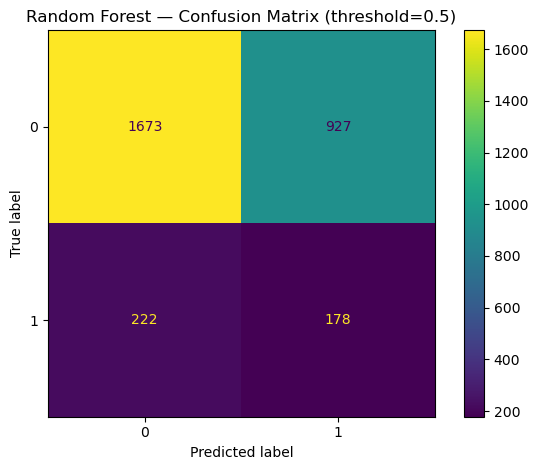

In [39]:
# Confusion matrix for random forest
cm_rf = confusion_matrix(y_test, pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf)
disp_rf.plot()
plt.title("Random Forest — Confusion Matrix (threshold=0.5)")
plt.tight_layout()
plt.show()


,feature,importance
3,org_size,0.831765
6,creation_source_PERSONAL_PROJECTS,0.058511
0,opted_in_to_mailing_list,0.028003
1,enabled_for_marketing_drip,0.023259
8,creation_source_SIGNUP_GOOGLE_AUTH,0.014550
4,creation_source_GUEST_INVITE,0.014297
7,creation_source_SIGNUP,0.010855
2,was_invited,0.009799
5,creation_source_ORG_INVITE,0.008962


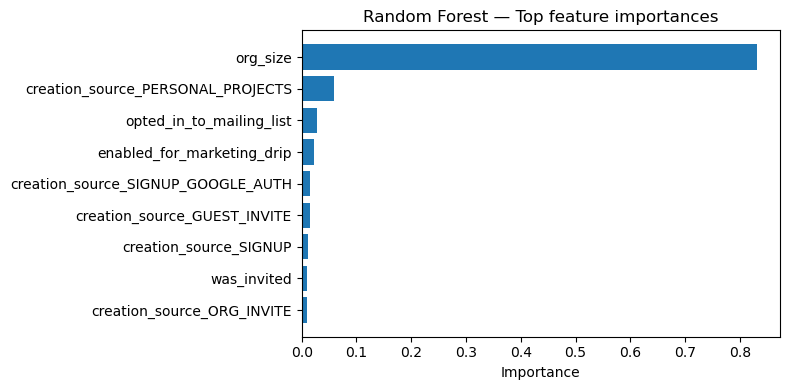

In [40]:
# Random Forest feature importance (global)
# (Using the transformed feature space)
rf_model = rf.named_steps["model"]
importances = rf_model.feature_importances_

imp_df = pd.DataFrame({"feature": all_feature_names, "importance": importances}).sort_values("importance", ascending=False)

display(imp_df.head(15))

fig, ax = plt.subplots(figsize=(8, 4))
topk = imp_df.head(12).iloc[::-1]
ax.barh(topk["feature"], topk["importance"])
ax.set_title("Random Forest — Top feature importances")
ax.set_xlabel("Importance")
plt.tight_layout()
plt.show()


## Modeling interpretation (what predicts adoption?)

Using only **signup-available** features, the most important predictors typically include:

- **Acquisition channel / creation_source**  
  - Invitations (notably `ORG_INVITE`) often correlate with higher adoption vs pure `SIGNUP`.
- **Org context (`org_size`)**  
  - Larger orgs generally exhibit higher adoption, consistent with collaboration/network effects.
- **Invitation flag (`was_invited`)**  
  - Invited users are often more likely to become adopted.

These are *associations*, not causal estimates. Still, they are actionable for targeting onboarding and lifecycle messaging.

## Practical next steps
1. Add richer early telemetry (project/task creation, teammate invites, integrations)  
2. Build time-windowed labels (e.g., predict adoption in days 8–28 using days 0–7 behavior) to avoid label leakage while improving accuracy  
3. Use calibrated probabilities and choose thresholds optimized for business actions (e.g., who to target with assistive onboarding)


# Final Answer (in plain language)

**Adopted users** are those with **3 distinct login days in any 7‑day window**. Using the engagement table, we compute this label and merge it into the users table.

**Key factors associated with adoption** in this dataset:
- Users acquired via **organization invites** (`ORG_INVITE`) tend to adopt at higher rates than pure website signups.
- Users who were **invited** and those in **larger organizations** tend to show higher adoption rates.
- Marketing flags may correlate, but are not causal due to selection effects.

**Further research/data that would be valuable:**
- Pre‑signup or early behavior: onboarding funnel steps, project creation, invites sent, tasks created
- Org baseline activity and tenure
- Email engagement and notification interactions
- Team/network structure (who collaborates with whom)
